<a href="https://colab.research.google.com/github/guevelel/COMP4449_Image_Classification/blob/main/Traffic_Signs_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

In [1]:
#Questions:
#What are the size, and coords features in the dataset?
#Set a random seed for repeatable results!
#run on gpu?
#
#Reconfigure heatmap to show what professor wants!
#

In [2]:
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 12.1 MB/s eta 0:00:00


In [3]:
#Import libraries:
import pandas as pd
import pickle
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [4]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

--2023-04-06 23:03:27--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip’

data_1.zip          100%[===================>]  30.59M  --.-KB/s    in 0.1s    

2023-04-06 23:03:28 (304 MB/s) - ‘dataroot/data_1.zip’ saved [32074743/32074743]

--2023-04-06 23:03:28--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.19

In [5]:
# Unzip github files into colab folders:
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [16]:
# Load sign names into a dictionary:
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
#signnames
#signnames.values()

In [7]:
# Load training, validation, and testing images:
train = pickle.load( open( dataroot+"train.p", "rb" ) )
val = pickle.load( open( dataroot+"valid.p", "rb" ) )
test = pickle.load( open( dataroot+"test.p", "rb" ) )

print(train.keys())
type(train)


dict_keys(['coords', 'labels', 'features', 'sizes'])


dict

The image shows a Turn left ahead sign


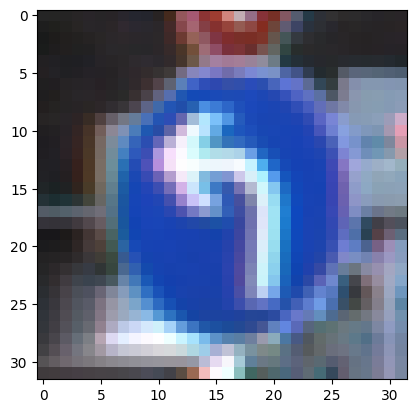

In [18]:
# Preview random image:
inx = 20123
plt.imshow(train['features'][inx])
print("The image shows a {} sign".format(signnames[train['labels'][inx]]))

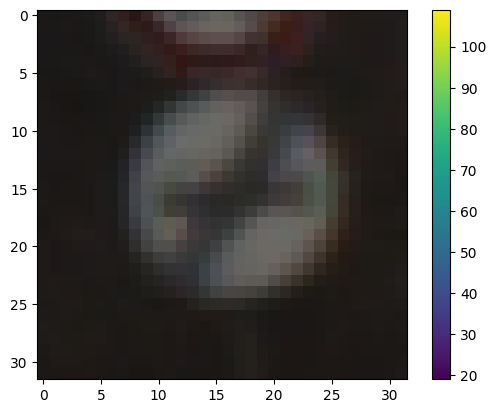

In [10]:

#https://levelup.gitconnected.com/pixels-arrays-and-images-ef3f03638fe7
#A color image is comprised of three channels: red, green, and blue.
#These channels correspond to the those in a single pixel.
#When a computer reads (or writes) an image, it takes the intensity values of each channel in a pixel 
#and stores them in corresponding cells of a 3D-array.

#https://www.tensorflow.org/tutorials/images/classification

plt.figure()
plt.imshow(train['features'][1])
plt.colorbar()
plt.grid(False)
plt.show()


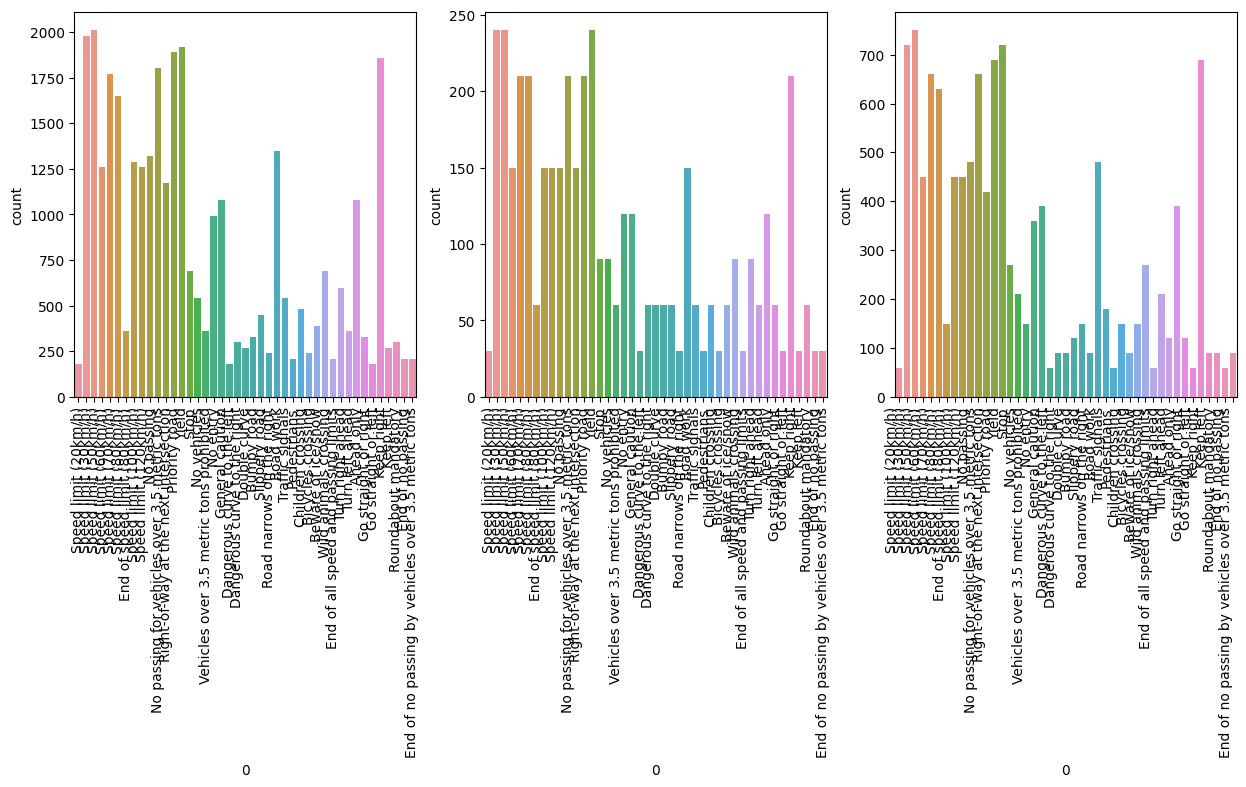

In [67]:
#Plot the distributions of the training, validation, and test data:

#Convert data to DF:
data_train = pd.DataFrame(train['labels'])
data_val = pd.DataFrame(val['labels'])
data_test = pd.DataFrame(test['labels'])

#Generate countplots:
fig, ax =plt.subplots(1,3, figsize=(15,5))
sns.countplot(data_train, x=data_train[0], ax=ax[0])
ax[0].set_xticklabels(list(signnames.values()))
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

sns.countplot(data_val, x=data_val[0], ax=ax[1])
ax[1].set_xticklabels(list(signnames.values()))
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)

sns.countplot(data_test, x=data_test[0], ax=ax[2])
ax[2].set_xticklabels(list(signnames.values()))
plt.xticks(rotation=90, ha='right')

plt.show()

In [13]:
#Split out data into training, validation, and test sets:
X_train = train['features']
y_train = train['labels']
X_val = val['features']
y_val = val['labels']
X_test = test['features']
y_test = test['labels']

#need to normalize images to feed into NN:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape and one hot encode:
y_train = tf.one_hot(y_train, 43)
y_val = tf.one_hot(y_val, 43)
y_test = tf.one_hot(y_test, 43)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 34799
number of test examples = 12630
X_train shape: (34799, 32, 32, 3)
Y_train shape: (34799, 43)
X_val shape: (4410, 32, 32, 3)
Y_val shape: (4410, 43)
X_test shape: (12630, 32, 32, 3)
Y_test shape: (12630, 43)


Now, the shape of our data is (34799, 32, 32, 3), where 34799 represents the number of images,32*32 represents the image sizes into pixels, and the last 3 represents the RGB value(availability of coloured data).

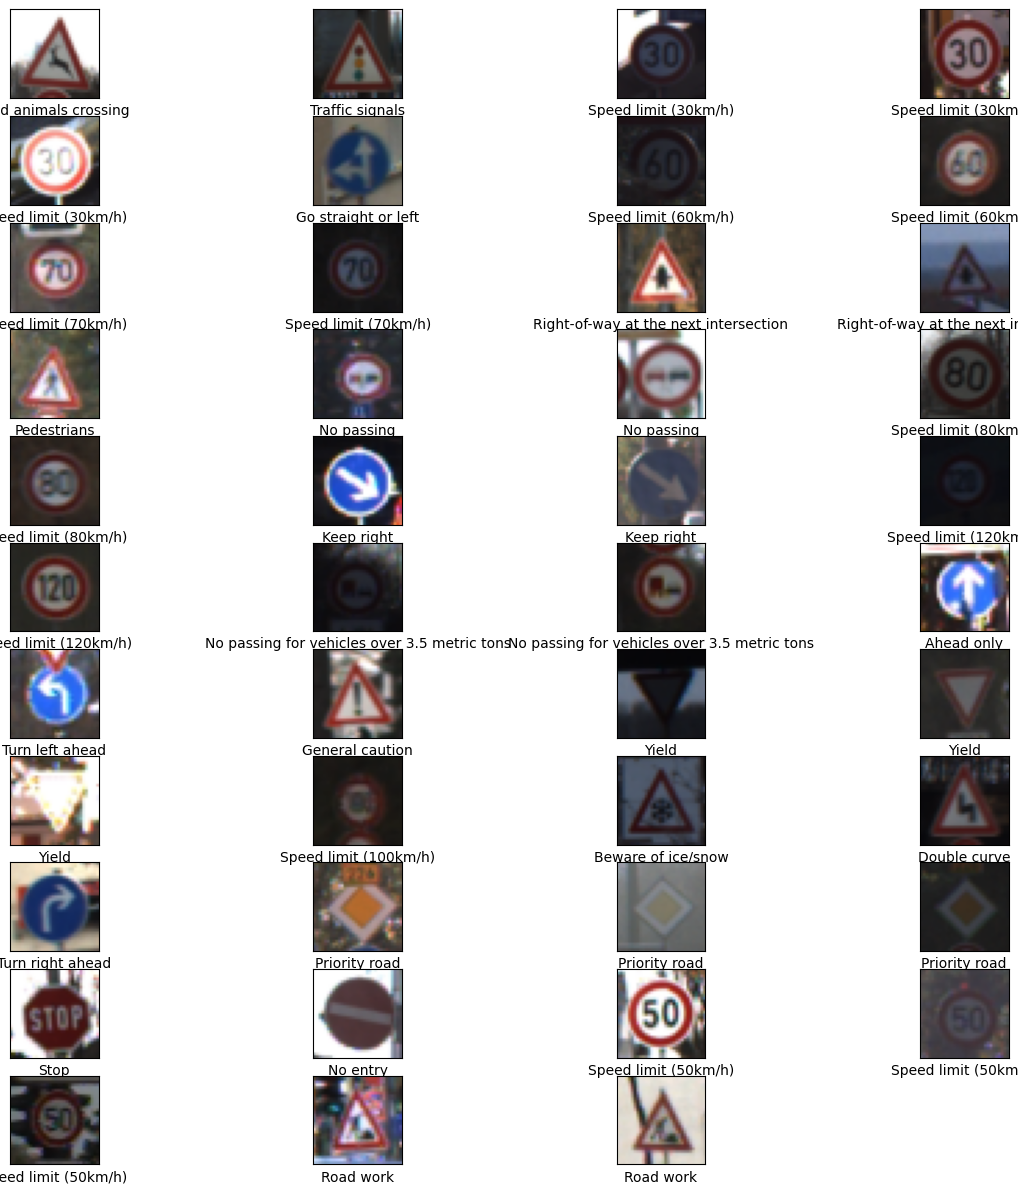

In [19]:
#Visualize all of the different road signs:
plt.figure(figsize=(15,15))
for i in range(808, 34799, 808):
    plt.subplot(11,4,int(i/808))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train['features'][i], cmap=plt.cm.binary)
    plt.xlabel(signnames[train['labels'][i]])

#plt.tight_layout#
plt.show()

In [20]:
#Build Neural Network Model: 

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#Dense layers are fully connected
#Convolutional, Pooling, LSTM
#Dropout
#Flatten
#Reshape
#Pooling
#Convolutional


In [21]:
#Set number of Epochs:
eps = 3

#Fit model and track the accuracy and loss:
history = model.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))


Epoch 1/3
1088/1088 [==============================] - 140s 127ms/step - loss: 1.0201 - accuracy: 0.7141 - val_loss: 0.4828 - val_accuracy: 0.8649
Epoch 2/3
1088/1088 [==============================] - 132s 122ms/step - loss: 0.3561 - accuracy: 0.8953 - val_loss: 0.4365 - val_accuracy: 0.8832
Epoch 3/3
1088/1088 [==============================] - 134s 123ms/step - loss: 0.2604 - accuracy: 0.9232 - val_loss: 0.4676 - val_accuracy: 0.8878


The history.history["loss"] entry is a dictionary with as many values as epochs that the model was trained on. 

<ipython-input-22-cffdc307f8dc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-22-cffdc307f8dc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

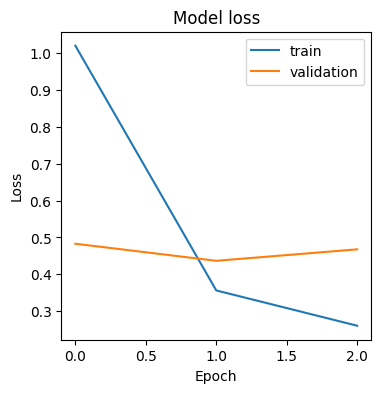

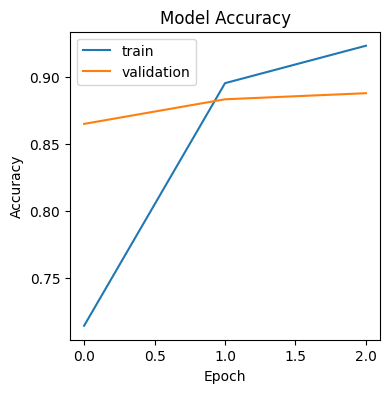

In [22]:
# Plot the train and validation accuracy and loss curves:
#df_loss_acc = pd.DataFrame(history.history)
#df_loss= df_loss_acc[['loss','val_loss']]
#df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
#df_acc= df_loss_acc[['accuracy','val_accuracy']]
#df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
#df_loss.plot(title='Model loss',figsize=(4,4)).set(xlabel='Epoch',ylabel='Loss')
#df_acc.plot(title='Model Accuracy',figsize=(4,4)).set(xlabel='Epoch',ylabel='Accuracy')


#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history.history)
print(df.head())

fig,ax=plt.subplots(figsize=(12,7))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

In [23]:
#Assess accuracy on Test set:
model.evaluate(X_test, y_test)

395/395 [==============================] - 9s 22ms/step - loss: 0.4867 - accuracy: 0.8865


[0.4866507947444916, 0.8865399956703186]

In [24]:
#Extract the model predictions on the test set (for confusion matrix building):

#history.history
pred = model.predict(X_test)
#pred


395/395 [==============================] - 9s 22ms/step


In [25]:
#Convert label matrices to index values for confustion matrix:

y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

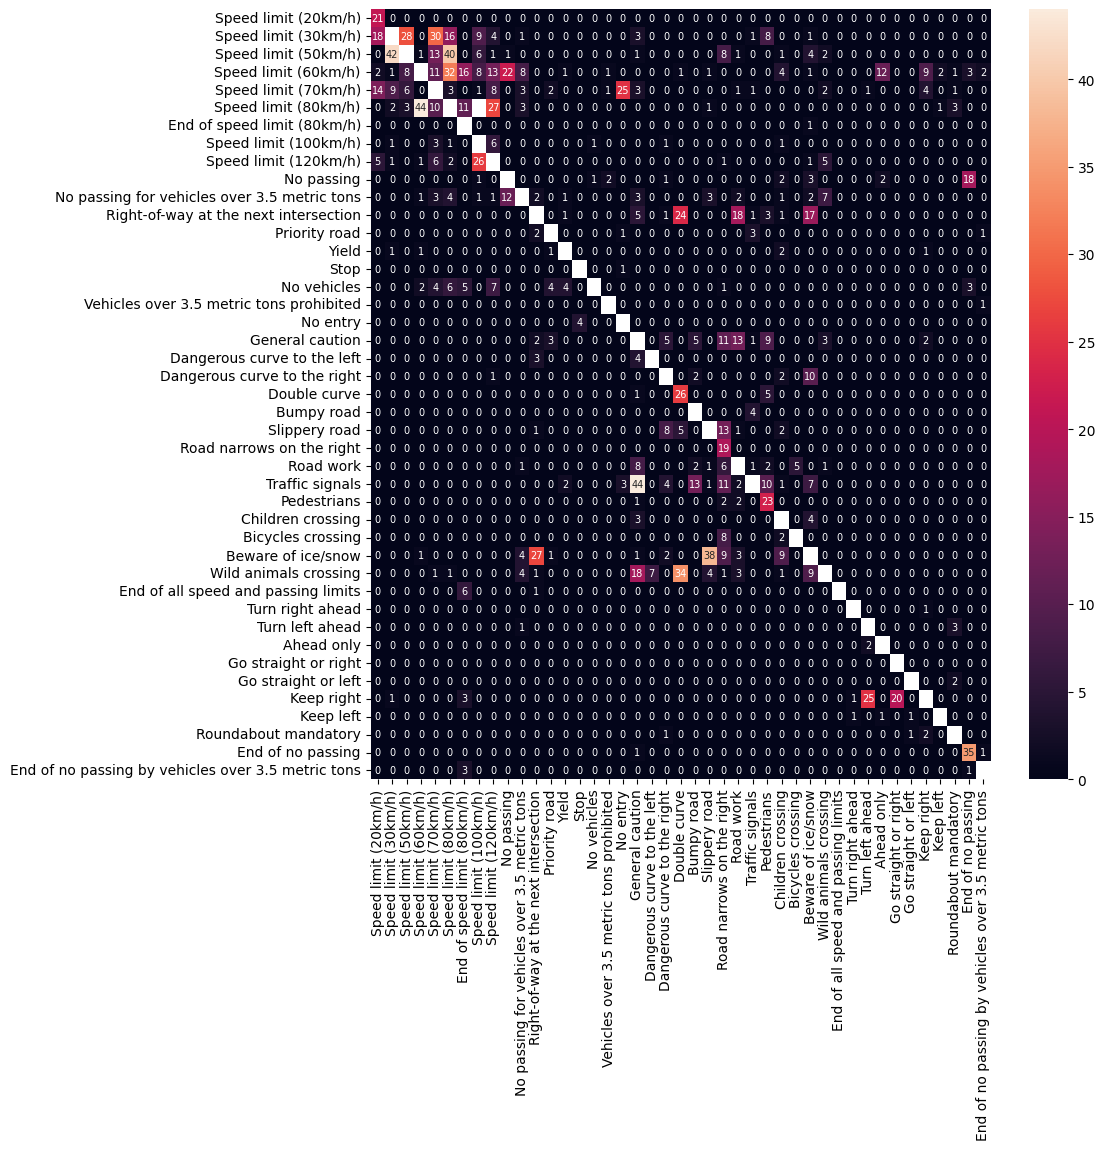

In [54]:
#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(10,10))
corr = confusion_matrix(y_preds, y_act)
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >50 )
            #cmap="YlOrRd_r")
plt.show()

In [36]:
#from sklearn import svm

# Support vector classifier
#classifier = svm.SVC(gamma=0.001)

# Learn to classify the training set
#classifier.fit(X_train, y_train)

In [37]:
#Notes:
#use random number generator to mimic incoming image
#
#X_train[0].shape
#torch.tensor(X_train[0]).shape

In [38]:
#

In [39]:
#history.history

In [35]:
'''
#Implement a Keras Classifier:
model2 = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(43, activation='softmax')
])


model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#loss functions: 'mean_squared_error', 'sparse_categorical_crossentropy', categorical_crossentropy
#Optimizers = keras.optimizers.SGD(learning_rate=1e-3), adam, Nadam, 
history2 = model2.fit(X_train, y_train, epochs=3, verbose=0, validation_data=(X_val, y_val))
mse_test = model2.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model2.predict(X_new)


#print("Keras Classifier RMSE:",np.sqrt(mse_test))
#print("Keras Classifier Score:", mlp.score(y_test, y_pred.reshape(-1, 1)))
'''

'\n#Implement a Keras Classifier:\nmodel2 = keras.models.Sequential([\n    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),\n    keras.layers.Dense(12, activation=\'relu\'),\n    keras.layers.Dropout(0.25),\n    keras.layers.Dense(16, activation=\'relu\'),\n    keras.layers.Dropout(0.25),\n    keras.layers.Dense(12, activation=\'relu\'),\n    keras.layers.Dropout(0.25),\n    keras.layers.Dense(6, activation=\'relu\'),\n    keras.layers.Flatten(),\n    keras.layers.Dense(43, activation=\'softmax\')\n])\n\n\nmodel2.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n#loss functions: \'mean_squared_error\', \'sparse_categorical_crossentropy\', categorical_crossentropy\n#Optimizers = keras.optimizers.SGD(learning_rate=1e-3), adam, Nadam, \nhistory2 = model2.fit(X_train, y_train, epochs=3, verbose=0, validation_data=(X_val, y_val))\nmse_test = model2.evaluate(X_test, y_test)\nX_new = X_test[:3]\ny_pred = model2.predict(X_new)\n\n\n#pri